### Mount Google Drive to runtime

In [3]:
from google.colab import drive
from os.path import join

# Mounting location on runtime for GDrive
ROOT = '/content/drive'

# Project workspace on GDrive
PROJECT_PATH = 'My Drive/Github'

# Mount GDrive on the runtime
drive.mount(ROOT)

# Create the full runtime project path and create a workspace at that location
WORKING_PATH = join(ROOT, PROJECT_PATH)
!mkdir "{WORKING_PATH}" 
%cd "{WORKING_PATH}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/Github’: File exists
/content/drive/My Drive/Github


### Install and import libraries

In [4]:
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import tempfile

import json
import string

import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
s = ['I am going NUM)BER.COST', 'to https://api.amazon.com/auth/o2/token school']
s.append([123])
s[1] = ['asdf']
print(s)
[123] in s

['I am going NUM)BER.COST', ['asdf'], [123]]


True

950
['questions', 'financial', 'management', 'category', 'use', 'please', 'sure', 'select', 'appropriate', 'sub-category', 'hi', 'using', 'prep', 'centers', 'much', 'cost', 'add', 'per', 'unit', 'account', 'expenses', 'prepping', 'center', 'trying', 'charges', 'receiving', 'boxes', 'tia', 'currently', 'paying', 'packaging', 'breakdown', 'close', 'single', '$0.90/unit', '########', 'packs', 'seems', 'high', 'lot', 'volume', 'still', 'new', 'speaking', 'cashback', 'hear', 'people', 'often', 'mention', 'one', 'business', 'purpose', 'visa', 'personal', 'checked', 'read', 'small', 'print', 'available', 'us', 'anyone', 'know', 'used', 'usa', 'non', 'citizen', 'good', 'question', 'luck', 'would', 'definitely', 'google', 'search', 'might', 'better', 'card', 'bank', 'home', 'country', 'you', 'is', 'reach', 'credit', 'cards', 'see', 'help', 'years', 'ago', 'moved', 'canada', 'i', 'history', 'issue', 'able', 'get', 'professional', 'member', 'but', 'helps', 'lizd', 'come', 'system', 'yet', 'making

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


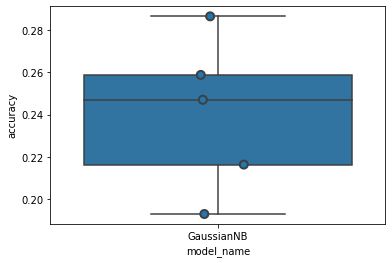

Management
Traffic Sources
Amazon Specific
Misc Topics
Fulfillment
Flowster-specific
Human Resources
Financial Management
Product Sourcing
Software & Tools
eCommerce Marketplaces

Management
Traffic Sources
Amazon Specific
Fulfillment
Flowster-specific
Human Resources
Financial Management
Product Sourcing
Software & Tools

Classification Report
                        precision    recall  f1-score   support

       Amazon Specific       0.75      0.25      0.38        24
  Financial Management       0.33      0.50      0.40         2
     Flowster-specific       0.38      0.31      0.34        16
           Fulfillment       0.57      0.57      0.57         7
       Human Resources       0.13      0.62      0.22         8
            Management       0.08      0.33      0.12         3
           Misc Topics       0.00      0.00      0.00         2
      Product Sourcing       0.50      0.16      0.24        25
      Software & Tools       0.25      0.50      0.33         2
       Traff

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
'''
@brief      Determine if a string consists only of ASCII characters
@param      s           Input string
@return     boolean    
'''
def is_ascii(s):
    return all(ord(c) < 128 for c in s)


'''
@brief      Performs pre-processing on scraped web data
@param      topicDict       Dictionary of topic attributes
@return     topicFeatures   List of pre-processed strings that represent each topic
@return     labels          List of each topic's ground truth category
'''
def cleanData(topicDict):
    # Get list of topics
    topics = list(topicDict.keys())

    # Create empty lists to store outputs
    topicFeatures = []
    labels = []

    count = 1
    for topic in topics:
        # Hardcoded line to omit category written in Chinese
        category = topicDict[topic]['Category']
        if (is_ascii(category) == False or category == 'Store & Website Management'):
            continue

        # Combine topic title and comments into one string
        title = topicDict[topic]['Topic Title']
        leadingComment = topicDict[topic]['Leading Comment']
        #otherComments = topicDict[topic]['Other Comments']
        
        featureList = [leadingComment] 
        featureString = ' '.join(featureList)

        # Replace newline and tab characters with spaces
        featureString = featureString.replace('\n', ' ')
        featureString = featureString.replace('\t', ' ')

        # Convert all letters to lowercase
        featureString = featureString.lower()
        
        # Strip all punctuation
        #table = str.maketrans('', '', string.punctuation)
        #featureString = featureString.translate(table)

        # Remove all non-ASCII characters
        #featureString = featureString.encode(encoding='ascii', errors='ignore').decode('ascii')

        # Split feature string into a list to perform processing on each word
        wordList = featureString.split()

        # Remove all stop words
        stop_words = set(stopwords.words('english'))
        wordList = [word for word in wordList if not word in stop_words]

        # Remove all words to contain non-ASCII characters
        wordList = [word for word in wordList if is_ascii(word)]

        # Remove all leading/training punctuation, except for '$'
        punctuation = '!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        wordList = [word.strip(punctuation) for word in wordList]

        # Replace all numbers with ######## identifier
        # Replace all costs with $$$$$$$$ identifier
        wordList = ['########' if (word.replace('.','').replace(',','').isdigit()) \
                    else '$$$$$$$$' if (word.replace('.','').replace(',','').replace('$','').isdigit()) \
                    else word \
                    for word in wordList]
        #wordList = ['########' if (word.replace('.','').isdigit()) else word for word in wordList]
        #wordList = ['########' if (word.translate(table).isdigit()) else word for word in wordList]

        # Reconstruct featureString
        # If it is empty, do not add this sample to the final output
        featureString = ' '.join(wordList)
        if (featureString.strip() == ''):
            continue

        # Print sample number and featureString
        #print(count)
        #count += 1
        #print(featureString)

        # Append featureString and the topic category to the output lists
        topicFeatures.append(featureString)
        labels.append(topicDict[topic]['Category'])

    return topicFeatures, labels



if __name__ == '__main__':
    # Extract topic attribute dictionary from JSON file
    #f = open('/content/drive/My Drive/Github/mlteam4/sandbox/Amazon_Topic_Attributes_20200617061621.json')
    f = open('/content/drive/My Drive/Github/mlteam4/flowster_webscraping/augmented_data_wcomment.json')
    topicDict = json.load(f)
    f.close()

    # Pre-process data
    topicFeatures, labels = cleanData(topicDict)


    print(len(topicDict.keys()))
    
    trainingSentences = []
    
    for sentence in topicFeatures:
        wordList = sentence.split()
        trainingSentences.append(wordList)

    #model = Word2Vec(sentences=trainingSentences, min_count=2, size=300)

    taggedTrainingSentences = [TaggedDocument(words=sentence, tags=[str(i)]) for i, sentence in enumerate(trainingSentences)]
    model = Doc2Vec(dm=1, vector_size=300, min_count=2, epochs=100)
    model.build_vocab(taggedTrainingSentences)
    model.train(taggedTrainingSentences, total_examples=model.corpus_count, epochs=model.epochs)
    
    vocab = [word for word in model.wv.vocab]
    print(vocab)

    #print(model.wv.most_similar(positive="amazon"))
    #print(model.wv.most_similar(positive="va"))
    #print(model.wv.most_similar(positive="account"))

    
    trainingSentences = [[word for word in sentence if (word in vocab)] for sentence in trainingSentences]

    topicVectors = [model.infer_vector(sentence) for sentence in trainingSentences]

         
    '''
    topicVectors = []
    for sentence in trainingSentences:
        topicVector = np.zeros(300)
        for word in sentence:
            topicVector += model.wv[word]
        topicVectors.append(topicVector)
    
    print(np.array(topicVectors)/len(sentence))
    '''


    # Initialize text vectorizer
    #vectorizer = CountVectorizer()
    #vectorizer = TfidfVectorizer()

    # Vectorize topic texts
    #X = vectorizer.fit_transform(topicFeatures)

    # It was found that if TF-IDF is used, accuracy can be improved by multiplying the vectors by a large number
    #X = 1000 * X

    #print(labels)

    # Split topic vectors and labels into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(topicVectors, labels, test_size=0.1)
    #X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=8)

    # Printouts for debugging
    #print(X)
    #print(X.toarray())
    #print(X.shape)
    #print(y_train)
    #print(vectorizer.get_feature_names())

    # Create 5-Fold object to perform cross-validation split on the training set
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_train)

    # Create multinominal Naive Bayes classifier
    gaussianClassifier = GaussianNB()

    # Train classifier and compute validation accuracy for each fold
    CV = 5
    #cv_df = pd.DataFrame(index=range(CV * len(models)))
    
    entries = []
    
    model_name = gaussianClassifier.__class__.__name__
    accuracies = cross_val_score(gaussianClassifier, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    #Caculating the mean of all models
    print(cv_df.groupby('model_name').accuracy.mean())
    
    seaborn.boxplot(x='model_name', y='accuracy', data=cv_df)
    seaborn.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    
    # Perform final trainining on the full training set
    gaussianClassifier.fit(X_train, y_train)

    # Perform final test set prediction and generate classification report
    y_predicted = gaussianClassifier.predict(X_test)

    for i in set(y_test):
        print(i)

    print()
    for i in set(y_predicted):
        print(i)

    print()
    print('Classification Report')
    print(classification_report(y_test, y_predicted, target_names=gaussianClassifier.classes_))
    
